In [75]:
import numpy as np
import matplotlib.pyplot as plt
import vice

from multizone.src.yields import J21
from multizone.src.models.utils import constant, exponential
from multizone.src.models.normalize import integrate_infall
from multizone.src.models import static, static_infall, fiducial_sf_law
from multizone.src.models.diskmodel import two_component_disk
from multizone.src.models.gradient import gradient
from multizone.src.models.mass_loading import no_outflows
import _globals

## Constant Infall

In [93]:
class static_gradient(static):
    def __init__(self, radius, dr=0.1, **kwargs):
        super().__init__(radius, dr=dr, **kwargs)
        area = np.pi * ((radius + dr/2.)**2 - (radius - dr/2.)**2)
        self.amplitude *= gradient(radius) * area

class static_infall_gradient(static_infall):
    def __init__(self, radius, dr=0.1, **kwargs):
        super().__init__(radius, dr=dr, **kwargs)
        area = np.pi * ((radius + dr/2.)**2 - (radius - dr/2.)**2)
        self.amplitude *= gradient(radius) * area

In [94]:
radius = 1
dr = 0.1
area = np.pi * ((radius + dr/2.)**2 - (radius - dr/2.)**2)
ifr = static_infall_gradient(radius, mass_loading=no_outflows)
tau_star = fiducial_sf_law(area)
eta = 0.
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta=eta, recycling=recycling, dt=dt)

In [95]:
name1 = '../data/onezone/int_test/static'
sfr = static_gradient(radius)
sz = vice.singlezone(
    name = name1,
    func = sfr,
    mode = "sfr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    recycling=recycling,
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

/opt/anaconda3/envs/twoinfall/lib/python3.12/site-packages/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)


In [96]:
name2 = '../data/onezone/int_test/static_infall'
sz = vice.singlezone(
    name = name2,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    recycling = recycling,
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

/opt/anaconda3/envs/twoinfall/lib/python3.12/site-packages/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)


592043100.0
596262500.0


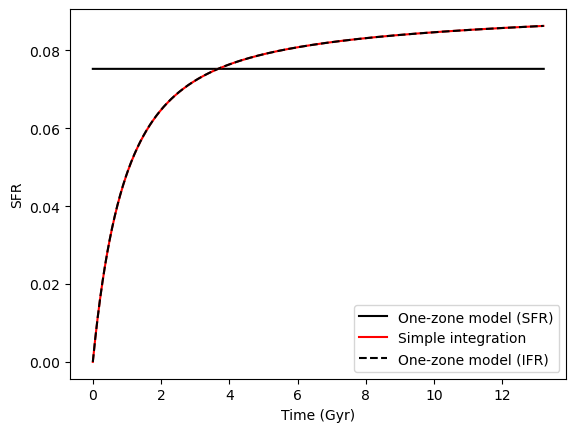

In [97]:
hist1 = vice.history(name1)
print(hist1['mstar'][-1])
hist2 = vice.history(name2)
print(hist2['mstar'][-1])

fig, ax = plt.subplots()
ax.plot(hist1['time'], hist1['sfr'], 'k-', label='One-zone model (SFR)')
ax.plot(times, [sfh_integrated(t) for t in times], 'r-', label='Simple integration')
ax.plot(hist2['time'], hist2['sfr'], 'k--', label='One-zone model (IFR)')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [99]:
sfh = [sfh_integrated(t) for t in simtime]
mstar = sum([sfr * dt * 1e9 * (1 - recycling) for sfr in sfh])
print(mstar / area)
print(hist1['mstar'][-1] / area)
print(hist2['mstar'][-1] / area)
print(sum(hist2['sfr']) * dt * 1e9 * (1 - recycling) / area)

949402302.2056646
942265858.8844928
948981242.5533122
950333645.2275242


In [7]:
# custom integrator with continuous recycling
times, sfh_continuous = integrate_infall(ifr, tau_star, eta, recycling='continuous', dt=dt)

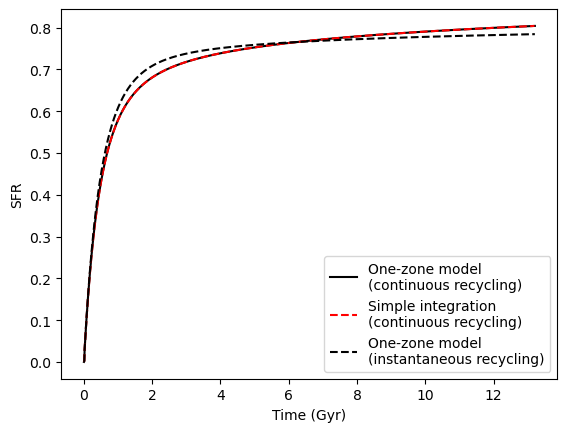

In [8]:
hist1 = vice.history(name1)
hist2 = vice.history(name2)

fig, ax = plt.subplots()
ax.plot(hist1['time'], hist1['sfr'], 'k-', label='One-zone model\n(continuous recycling)')
ax.plot(times, sfh_continuous, 'r--', label='Simple integration\n(continuous recycling)')
ax.plot(hist2['time'], hist2['sfr'], 'k--', label='One-zone model\n(instantaneous recycling)')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

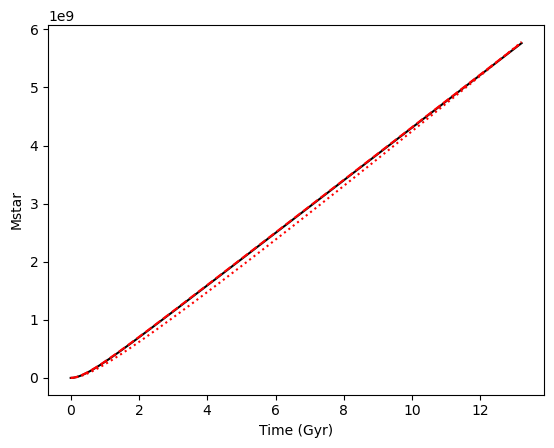

In [9]:
mstar_pred = calculate_mstar(hist1['sfr'], recycling='continuous')
mstar_approx = calculate_mstar(hist1['sfr'], recycling=0.4)

fig, ax = plt.subplots()
ax.plot(hist1['time'], hist1['mstar'], 'k-', label='One-zone model')
ax.plot(hist1['time'], mstar_pred, 'r--', label='Predicted')
ax.plot(hist1['time'], mstar_approx, 'r:', label='Approximate')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('Mstar')
plt.show()

## Exponential Infall

In [10]:
ifr = exponential(timescale=1, norm=1)
tau_star = twoinfall_sf_law(1, factor=1)
eta = 2
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta)

In [11]:
name = '../data/onezone/int_test/exponential'
sz = vice.singlezone(
    name = name,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    # recycling = recycling
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

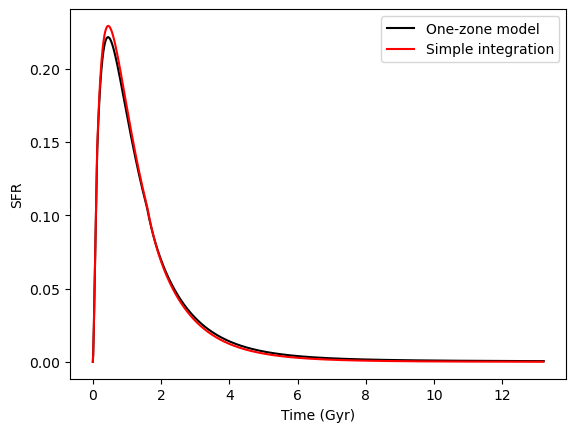

In [12]:
hist = vice.history(name)

fig, ax = plt.subplots()
ax.plot(hist['time'], hist['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [13]:
mstar = sum(sfh_integrated) * dt * 1e9 * (1 - recycling)
print(mstar)
print(hist['mstar'][-1])
print(sum(hist['sfr']) * dt * 1e9 * (1 - recycling))

231522979.24543843
219961400.0
234011673.93360004


## Two-Infall Model

In [15]:
radius = 0.05
dr = 0.1
area = np.pi * ((radius + dr)**2 - radius**2)
ifr = twoinfall(radius, first_timescale=1, second_timescale=10, onset=4)
tau_star = twoinfall_sf_law(area, onset=4)
eta = vice.milkyway.default_mass_loading(radius)
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta, recycling=recycling, dt=dt)

In [16]:
name1 = '../data/onezone/int_test/twoinfall1'
sz = vice.singlezone(
    name = name1,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    # recycling = recycling
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

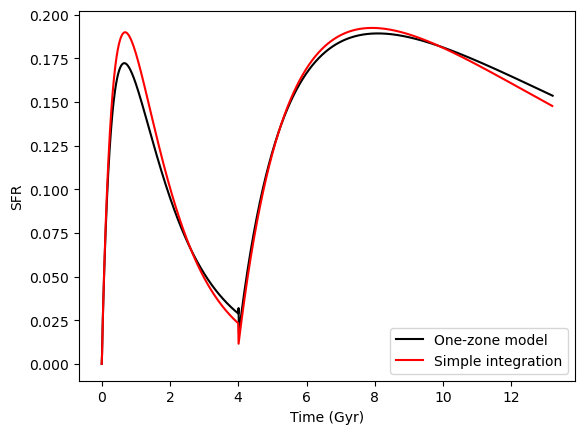

In [17]:
hist = vice.history(name1)

fig, ax = plt.subplots()
ax.plot(hist['time'], hist['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [18]:
mstar = sum(sfh_integrated) * dt * 1e9 * (1 - recycling)
print(mstar)
print(hist['mstar'][-1])
print(sum(hist['sfr']) * dt * 1e9 * (1 - recycling))

1138060617.4623275
1128487000.0
1127861113.23


In [19]:
mstar_at_onset = sum(sfh_integrated[:400]) * dt * 1e9 * (1 - recycling)
print(mstar_at_onset)
print(hist['mstar'][399])
print(sum(hist['sfr'][:400]) * dt * 1e9 * (1 - recycling))

240063793.86304376
237144600.0
227371990.22999996


In [20]:
print(hist['sfr'][1])

0.005421215


In [21]:
print(mstar_at_onset / (mstar - mstar_at_onset))

0.267332564608456


In [22]:
print(hist['mstar'][399] / (hist['mstar'][-1] - hist['mstar'][399]))

0.26605331464092813


In [23]:
mw_disk = two_component_disk()
print(mw_disk.thick_to_thin(0))
print(mw_disk.thick_to_thin(8))

0.27
0.12131882031164984


In [24]:
ifr = twoinfall(radius, first_timescale=1, second_timescale=10, onset=4, recycling='continuous')
times, sfh_continuous = integrate_infall(ifr, tau_star, eta, recycling='continuous', dt=dt)

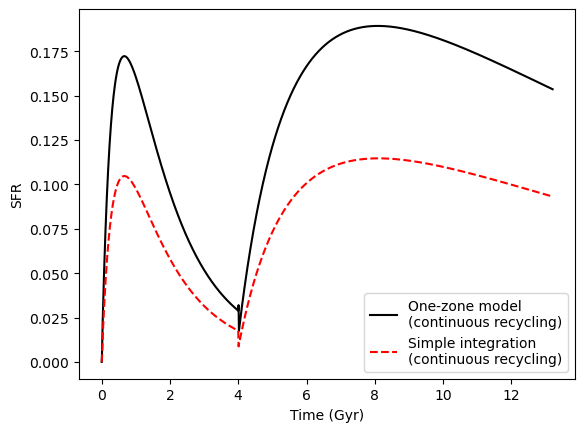

In [25]:
hist1 = vice.history(name1)

fig, ax = plt.subplots()
ax.plot(hist1['time'], hist1['sfr'], 'k-', label='One-zone model\n(continuous recycling)')
ax.plot(times, sfh_continuous, 'r--', label='Simple integration\n(continuous recycling)')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [26]:
mstar_at_onset = (sum(sfh_continuous[:400]) - continuous_recycling(sfh_continuous[:400])) * dt * 1e9
print(mstar_at_onset)
print(hist['mstar'][399])
print(sum(hist['sfr'][:400]) * dt * 1e9 * (1 - recycling))

230379903.62872854
237144600.0
227371990.22999996


### Variant

In [27]:
radius = 8
dr = 0.1
area = np.pi * ((radius + dr)**2 - radius**2)
ifr = twoinfall(radius, first_timescale=1, second_timescale=1, onset=4)
tau_star = twoinfall_sf_law(area, onset=4)
eta = 2.15
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta, recycling=recycling, dt=dt)

In [28]:
name2 = '../data/onezone/int_test/twoinfall2'
sz = vice.singlezone(
    name = name2,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    # recycling = recycling
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

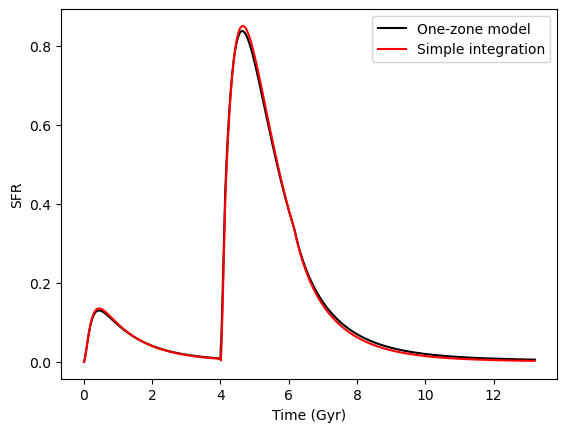

In [29]:
hist = vice.history(name2)

fig, ax = plt.subplots()
ax.plot(hist['time'], hist['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [30]:
mstar = sum(sfh_integrated) * dt * 1e9 * (1 - recycling)
print(mstar)
print(hist['mstar'][-1])
print(sum(hist['sfr']) * dt * 1e9 * (1 - recycling))

1134105371.9919343
1106092000.0
1150151198.406


In [31]:
mstar_at_onset = sum(sfh_integrated[:400]) * dt * 1e9 * (1 - recycling)
print(mstar_at_onset)
print(hist['mstar'][399])
print(sum(hist['sfr'][:400]) * dt * 1e9 * (1 - recycling))

125246986.91470717
128055900.0
123970563.648


In [32]:
print(mstar_at_onset / (mstar - mstar_at_onset))

0.12414724283143033


In [33]:
print(hist['mstar'][399] / (hist['mstar'][-1] - hist['mstar'][399]))

0.13093167010910947


## vs radius

In [51]:
zones = [0, 1, 80, 140]
dr = 0.1
dt = 0.01
simtime = np.arange(0., 13.21, 0.01)
for z in zones:
    radius = (z + 0.5) * dr
    area = np.pi * ((radius + dr/2)**2 - (radius - dr/2)**2)
    ifr = twoinfall(radius, first_timescale=1, second_timescale=10, onset=4,
                   dr=dr, dt=dt)
    print(ifr.first.norm)
    tau_star = twoinfall_sf_law(area, onset=4)
    name = '../data/onezone/int_test/zone%d' % z
    sz = vice.singlezone(
        name = name,
        func = ifr,
        mode = "ifr",
        **_globals.ONEZONE_DEFAULTS
    )
    sz.eta = vice.milkyway.default_mass_loading(radius)
    sz.tau_star = tau_star
    sz.dt = dt
    sz.run(simtime, overwrite=True)

0.2724256209735334
0.2748134183934262
0.5897415225908378
1.0095074195938287


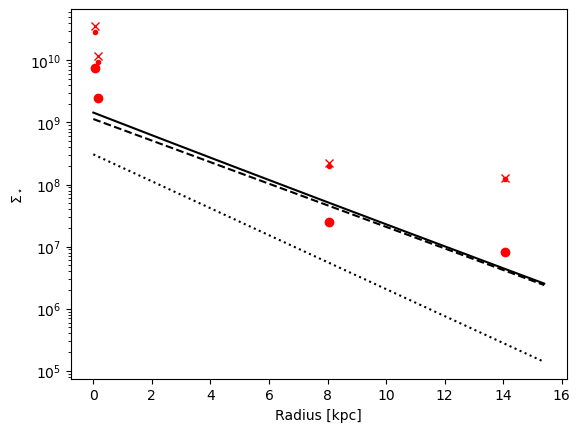

In [52]:
fig, ax = plt.subplots()
mw_disk = two_component_disk()
rbins = np.arange(0., 15.5, 0.1)
ax.plot(rbins, [mw_disk(r) for r in rbins], 'k-')
ax.plot(rbins, [mw_disk.thick_disk(r) for r in rbins], 'k:')
ax.plot(rbins, [mw_disk.thin_disk(r) for r in rbins], 'k--')

radii = []
mstar_total = []
mstar_thick = []
mstar_thin = []
for z in zones:
    radius = (z + 0.5) * dr
    radii.append(radius)
    area = np.pi * ((radius + dr/2)**2 - (radius - dr/2)**2)
    name = '../data/onezone/int_test/zone%d' % z
    hist = vice.history(name)
    onset = 4
    mstar_total.append(hist['mstar'][-1] / area)
    mstar_thick.append(hist['mstar'][int(onset/dt)-1] / area)
    mstar_thin.append((mstar_total[-1] - mstar_thick[-1]))

ax.plot(radii, mstar_total, 'rx')
ax.plot(radii, mstar_thick, 'ro')
ax.plot(radii, mstar_thin, 'r.')

ax.set_xlabel('Radius [kpc]')
ax.set_ylabel(r'$\Sigma_\star$')
ax.set_yscale('log')

plt.show()